In [4]:
import os
import numpy as np
from torchvision import transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from diffusers.models.vae import Decoder

#### Этапы и компоненты модели MindEye2
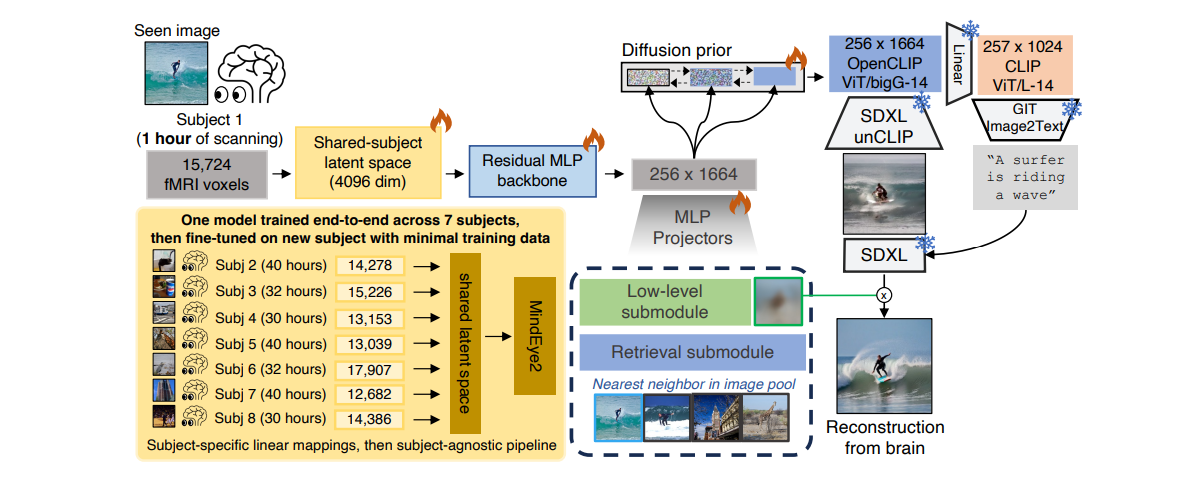

1. **Функциональное выравнивание**:
   - **Линейное отображение**: Каждый субъект имеет уникальную организацию мозга, поэтому данные fMRI сначала линейно отображаются в общее латентное пространство размерностью 4096. Это делается с помощью субъект-специфического линейного слоя с регуляризацией (ridge regression).
   - **Общее латентное пространство**: После линейного отображения данные fMRI всех субъектов оказываются в общем латентном пространстве, что позволяет использовать общую модель для всех субъектов.

2. **Основной блок (Residual MLP backbone)**:
   - **Входные данные**: Латентные представления размерностью 4096.
   - **Архитектура**: Основной блок состоит из 4 резидентных блоков MLP (Multi-Layer Perceptron).
   - **Выходные данные**: Латентные представления размерностью 4096.

3. **Диффузионный приор**:
   - **Входные данные**: Латентные представления размерностью 4096.
   - **Архитектура**: Диффузионный приор отображает латентные представления в пространство токенов изображений OpenCLIP ViT-bigG/14 (размерность 256x1664).
   - **Выходные данные**: Эмбеддинги токенов изображений OpenCLIP ViT-bigG/14.

4. **Подмодули**:
   - **Подмодуль поиска (Retrieval submodule)**: Использует контрастное обучение для максимизации косинусного сходства для положительных пар и минимизации для отрицательных пар.
   - **Подмодуль низкоуровневых признаков (Low-level submodule)**: Отображает латентные представления в пространство вариационного автоэнкодера (VAE) Stable Diffusion для получения размытых реконструкций.

5. **Генерация изображений**:
   - **Stable Diffusion XL (SDXL)**: Используется для генерации изображений из эмбеддингов OpenCLIP ViT-bigG/14. Модель была дообучена для принятия эмбеддингов изображений вместо текстовых эмбеддингов.
   - **Уточнение реконструкций**: Генерируемые изображения уточняются с помощью базовой модели SDXL и текстовых подписей, предсказанных из данных fMRI.

#### Размерности энкодера fMRI

1. **Входные данные fMRI**:
   - **Размерность**: 13,000 до 18,000 вокселей в зависимости от субъекта.

2. **Линейное отображение**:
   - **Выходная размерность**: 4096.

3. **Основной блок (Residual MLP backbone)**:
   - **Входная размерность**: 4096.
   - **Выходная размерность**: 4096.

4. **Диффузионный приор**:
   - **Входная размерность**: 4096.
   - **Выходная размерность**: 256x1664 (эмбеддинги токенов изображений OpenCLIP ViT-bigG/14).

5. **Подмодули**:
   - **Подмодуль поиска (Retrieval submodule)**:
     - **Входная размерность**: 4096.
     - **Выходная размерность**: 256x1664 (эмбеддинги токенов изображений OpenCLIP ViT-bigG/14).
   - **Подмодуль низкоуровневых признаков (Low-level submodule)**:
     - **Входная размерность**: 4096.
     - **Выходная размерность**: (64, 64, 4) (латентные представления VAE Stable Diffusion).

Модель MindEye2 использует сложную архитектуру для преобразования данных fMRI в латентное пространство, совместное с пространством CLIP, и затем генерирует изображения с помощью Stable Diffusion XL. Основные размерности включают 4096 для латентных представлений и 256x1664 для эмбеддингов токенов изображений OpenCLIP ViT-bigG/14.

Вроде бы Входные данные x имеют три измерения: [batch_size, seq_len, h].
- seq_len: длина последовательности (количество временных шагов или токенов).
- h: размерность скрытого состояния.

In [25]:
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, out_dim=768, seq_len=2, n_blocks=4, drop=.15, clip_size=768, blurry_recon=True, clip_scale=1):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        self.blurry_recon = blurry_recon
        self.clip_scale = clip_scale
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
        
        if self.blurry_recon:
            self.blin1 = nn.Linear(h*seq_len,4*28*28,bias=True)
            self.bdropout = nn.Dropout(.3)
            self.bnorm = nn.GroupNorm(1, 64)
            self.bupsampler = Decoder(
                in_channels=64,
                out_channels=4,
                up_block_types=["UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D"],
                block_out_channels=[32, 64, 128],
                layers_per_block=1,
            )
            self.b_maps_projector = nn.Sequential(
                nn.Conv2d(64, 512, 1, bias=False),
                nn.GroupNorm(1,512),
                nn.ReLU(True),
                nn.Conv2d(512, 512, 1, bias=False),
                nn.GroupNorm(1,512),
                nn.ReLU(True),
                nn.Conv2d(512, 512, 1, bias=True),
            )
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if self.clip_scale>0:
            c = self.clip_proj(backbone)

        if self.blurry_recon:
            b = self.blin1(x)
            b = self.bdropout(b)
            b = b.reshape(b.shape[0], -1, 7, 7).contiguous()
            b = self.bnorm(b)
            b_aux = self.b_maps_projector(b).flatten(2).permute(0,2,1)
            b_aux = b_aux.view(len(b_aux), 49, 512)
            b = (self.bupsampler(b), b_aux)
        
        return backbone, c, b

In [26]:
hidden_dim = 4096
clip_seq_dim = 256
clip_emb_dim = 1664

encoder = BrainNetwork(h=hidden_dim, seq_len=1, clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 

Под каждого объета обучим проекцию в общее латентное пространство

In [7]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out
        
# ridge = RidgeRegression([num_voxels], out_features=hidden_dim)

In [10]:
batch = torch.rand(128, 1, 4096)

In [14]:
backbone, c, b = encoder(batch)

In [24]:
print(backbone.shape, c.shape, b[0].shape)

torch.Size([128, 256, 1664]) torch.Size([128, 256, 1664]) torch.Size([128, 4, 28, 28])
